Importar librerías

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
import pickle
import time

PUNTO 2: EDA

1. Leer CSV

In [39]:
df_available = pd.read_csv("attrition_availabledata_03.csv")

2. Calculando el número de variables e instancias

In [40]:
print("\n🔹 Número de instancias y variables:")
print(f"Filas: {df_available.shape[0]}, Columnas: {df_available.shape[1]}")


🔹 Número de instancias y variables:
Filas: 2940, Columnas: 31


3. Identificando todos los tipos de variables (Categóricas, numéricas y ordinales)

In [41]:
col_categoricas = df_available.select_dtypes(include=['object']).columns.tolist()
col_numericas = df_available.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\n🔹 Variables categóricas:", col_categoricas)
print("\n🔹 Nº variables categóricas: " , len(col_categoricas))
print("🔹 Variables numéricas:", col_numericas)
print("\n🔹 Nº variables numéricas: " , len(col_numericas))


🔹 Variables categóricas: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Attrition']

🔹 Nº variables categóricas:  8
🔹 Variables numéricas: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

🔹 Nº variables numéricas:  23


4. Clasificación de todas las variables segun su cardinalidad

    Consideramos alta cardinalidas a vatiables con mas de 5 posibles valores

In [42]:
col_cardinalidad_alta = [col for col in col_categoricas if df_available[col].nunique() > 5]
print("\n🔹 Variables categóricas con alta cardinalidad:", col_cardinalidad_alta)


🔹 Variables categóricas con alta cardinalidad: ['EducationField', 'JobRole']


5. Identificación de las variables que tienen valor nulo

In [43]:
valores_nulos = df_available.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0]
print("\n🔹 Valores nulos por columna:")
print(valores_nulos)


🔹 Valores nulos por columna:
EnvironmentSatisfaction    15
JobSatisfaction            12
WorkLifeBalance            21
NumCompaniesWorked         13
TotalWorkingYears           6
dtype: int64


6. Detección de las columnas constantes de un solo valor

In [44]:
col_constantes = [col for col in df_available.columns if df_available[col].nunique() == 1]
print("\n🔹 Columnas constantes (sin variabilidad):", col_constantes)


🔹 Columnas constantes (sin variabilidad): ['EmployeeCount', 'Over18', 'StandardHours']


7. Detección de columnas binarias

In [45]:
col_binarias = [col for col in df_available.columns if df_available[col].nunique() == 2]
print("\n🔹 Columnas binarias:", col_binarias)


🔹 Columnas binarias: ['PerformanceRating', 'Gender', 'Attrition']


8. Identificando columnas de identificación

In [46]:
id_cols = [col for col in df_available.columns if "ID" in col or "id" in col or "EmployeeCount" in col]
print("\n🔹 Posibles columnas de ID:", id_cols)


🔹 Posibles columnas de ID: ['EmployeeCount', 'EmployeeID']


10. Análisis del desbalanceo de "Attrition"

10.1. Primero hacemos un análisis del tipo de problema con el que estamos tratando

In [47]:
target_col = "Attrition"
if df_available[target_col].dtype == 'object' or df_available[target_col].nunique() <= 10:
    print("\n🔹 Es un problema de CLASIFICACIÓN.")
else:
    print("\n🔹 Es un problema de REGRESIÓN.")


🔹 Es un problema de CLASIFICACIÓN.


10.2. Si es un problema de clasificación hacemos un análisis del desbalanceo de la variable objetivo

In [48]:
attrition_distribution = df_available[target_col].value_counts(normalize=True) * 100
print("\n🔹 Distribución de la variable objetivo (absences):")
print(attrition_distribution)


🔹 Distribución de la variable objetivo (absences):
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


10.3. Generando la visualización del desbalanceo

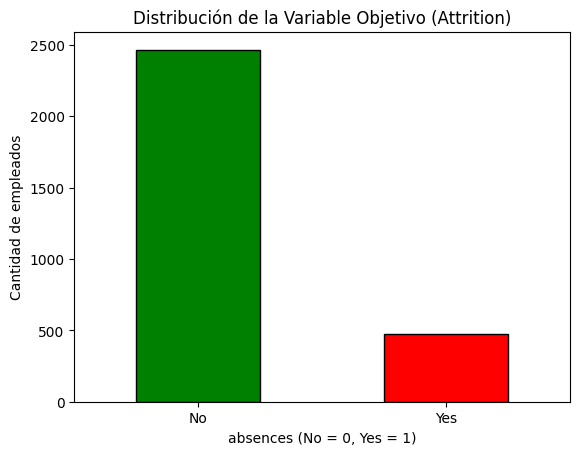

In [49]:
df_available["Attrition"].value_counts().plot(kind='bar', color=['green', 'red'], edgecolor="black")
plt.title("Distribución de la Variable Objetivo (Attrition)")
plt.ylabel("Cantidad de empleados")
plt.xlabel("absences (No = 0, Yes = 1)")
plt.xticks(rotation=0)
plt.show()

---------------------------------------------------------------------

PUNTO 3: CROSS VALIDATION

1. Eliminación de datos irrelevantes

    Estas columnas son identificadores "EmployeeID" y valores constantes

In [50]:
# Eliminar columnas irrelevantes
drop_columns = ["EmployeeID", "Over18", "StandardHours", "EmployeeCount"]
df = df_available.drop(columns=drop_columns, errors='ignore')

2. Convertir todas las variables a tipo numérico y separar según características y variable objetivo (Attrition)

In [51]:
# Convertir variables categóricas a numéricas usando Label Encoding
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Guardar para futuras conversiones si es necesario

# Separar en características (X) y variable objetivo (y)
X = df.drop(columns=["Attrition"])
y = df["Attrition"]

3. Preprocesamiento de datos: detección de outliers y escalado

3.1. Seleccionando columnas numéricas

In [52]:
df = X

numerical_cols = df.select_dtypes(include=
[np.number]).columns.tolist()

3.2. Función para detectar outliers usando regla IQR

In [53]:
def porcentaje_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    # Definir límites
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((col < lower_bound) | (col > upper_bound)).sum()
    return outlier_count / len(col)

3.3. Definiendo umbrales para la recomendación
    
    - Si la asimentría es mayor a 1 o menor a -1 se considera alta asimetría
    - Si más del 5% de las instancias son outliers

In [54]:
umbral_skew = 1.0
umbral_out = 0.05

print("Recomendación de transformación para cada columna numérica:")
print("-" * 70)

robust_columns = []
standard_columns = []

for col in numerical_cols:
    serie = df[col]
    skew = serie.skew()
    outlier_pct = porcentaje_outliers(serie)
    desc = serie.describe()
    
    print(f"\nColumna: {col}")
    print(f"  Media: {desc['mean']:.3f}, Std: {desc['std']:.3f}")
    print(f"  Mín: {desc['min']}, Máx: {desc['max']:.3f}")
    print(f"  Asimetría (skew): {skew:.3f}")
    print(f"  Porcentaje de outliers (IQR): {outlier_pct*100:.2f}%")
    
    # Lógica de recomendación
    if abs(skew) > umbral_skew or outlier_pct > umbral_out:
        robust_columns.append(col)
        print("  -> Sugerencia: La distribución es sesgada y/o presenta outliers; se recomienda normalización o escalado robusto.")
    else:
        standard_columns.append(col)
        print("  -> Sugerencia: Distribución aproximadamente normal; se recomienda estandarización con StandardScaler.")

Recomendación de transformación para cada columna numérica:
----------------------------------------------------------------------

Columna: hrs
  Media: 7.326, Std: 1.334
  Mín: 5.4168797411869445, Máx: 10.937
  Asimetría (skew): 0.859
  Porcentaje de outliers (IQR): 2.62%
  -> Sugerencia: Distribución aproximadamente normal; se recomienda estandarización con StandardScaler.

Columna: absences
  Media: 12.702, Std: 5.518
  Mín: 1.0, Máx: 24.000
  Asimetría (skew): 0.015
  Porcentaje de outliers (IQR): 0.00%
  -> Sugerencia: Distribución aproximadamente normal; se recomienda estandarización con StandardScaler.

Columna: JobInvolvement
  Media: 2.740, Std: 0.718
  Mín: 1.0, Máx: 4.000
  Asimetría (skew): -0.516
  Porcentaje de outliers (IQR): 0.00%
  -> Sugerencia: Distribución aproximadamente normal; se recomienda estandarización con StandardScaler.

Columna: PerformanceRating
  Media: 3.161, Std: 0.367
  Mín: 3.0, Máx: 4.000
  Asimetría (skew): 1.847
  Porcentaje de outliers (IQR): 16

3.4. Intanciación y aplicación de escaladores

In [55]:
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

# Aplicar las transformaciones de forma separada
X_transformed = X.copy()

if robust_columns:
    X_transformed[robust_columns] = robust_scaler.fit_transform(X[robust_columns])
if standard_columns:
    X_transformed[standard_columns] = standard_scaler.fit_transform(X[standard_columns])

4. Division de datos y configuración de Cross-Validation

    Se usa el parametro stratify para mantener la proporción de clases en Train y Test. Debido al desbalanceo de clases que se vio en el EDA.

In [56]:
# Dividir en Train (2/3) y Test (1/3)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=1/3, random_state=3, stratify=y)

# Guardar el scaler para futuros usos- No hace falta 
# with open("robust_scaler.pkl", "wb") as f:
#     pickle.dump(robust_scaler, f)
# with open("standard_scaler.pkl", "wb") as f:
#     pickle.dump(standard_scaler, f)

# Evaluación INNER: K-Fold Cross Validation (k=5)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

print("Datos preparados: Train (2/3), Test (1/3), y Cross-Validation lista.")


Datos preparados: Train (2/3), Test (1/3), y Cross-Validation lista.


5. Evaluación outer: Estimación de rendimiento con un modelo base

In [57]:
# Entrenar modelo base en Train
model = DecisionTreeClassifier(random_state=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=3)

In [58]:
# Predecir en el conjunto de Test (Outer Evaluation)
y_pred = model.predict(X_test)

In [59]:
# Cálculo de métricas
balanced_acc = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [60]:
# Matriz de confusión para obtener TPR y TNR
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

In [61]:
# True Positive Rate (TPR) y True Negative Rate (TNR)
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)

# 📌 Mostrar resultados
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")
print(f"Matriz de Confusión:\n{conf_matrix}")

Balanced Accuracy: 0.8580
Accuracy: 0.9204
True Positive Rate (TPR): 0.7658
True Negative Rate (TNR): 0.9501
Matriz de Confusión:
[[781  41]
 [ 37 121]]


5. HPO:  REVISAR

In [62]:
# # Definir el espacio de hiperparámetros a optimizar
# param_grid = {
#     'max_depth': [3, 5, 7, None],
#     'min_samples_split': [2, 5, 10]
# }

# # Usar el mismo kfold definido para la evaluación inner
# grid_search = GridSearchCV(
#     estimator=DecisionTreeClassifier(random_state=3),
#     param_grid=param_grid,
#     scoring='balanced_accuracy',
#     cv=kfold,  # Evaluación inner con validación cruzada estratificada (k=5)
#     n_jobs=-1
# )

# # Ajustar en el conjunto de entrenamiento
# grid_search.fit(X_train, y_train)

# # Imprimir los mejores hiperparámetros y la métrica de inner evaluation
# print("Mejores hiperparámetros:", grid_search.best_params_)
# print("Puntuación inner (Balanced Accuracy):", grid_search.best_score_)

--------------------------------------------------------------------------------------

PUNTO 4: MÉTODOS BÁSICOS (KNN y Árboles de decisión)

1. Escalar e imputar usando KNN como referencia

In [63]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

imputers = {
    "Mean": SimpleImputer(strategy="mean"),
    "Median": SimpleImputer(strategy="median")
}

2. Evaluando con KNN (k=5) para decidir el mejor método

In [64]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
best_score = 0
best_scaler = None
best_imputer = None

for scaler_name, scaler in scalers.items():
    for imputer_name, imputer in imputers.items():
        X_train_imputed = imputer.fit_transform(X_train)
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        
        knn = KNeighborsClassifier(n_neighbors=5)
        score = np.mean(cross_val_score(knn, X_train_scaled, y_train, cv=kfold, scoring="balanced_accuracy"))
        
        print(f"Scaler: {scaler_name}, Imputer: {imputer_name}, Score: {score:.4f}")
        
        if score > best_score:
            best_score = score
            best_scaler = scaler
            best_imputer = imputer

Scaler: StandardScaler, Imputer: Mean, Score: 0.5922
Scaler: StandardScaler, Imputer: Median, Score: 0.5928
Scaler: MinMaxScaler, Imputer: Mean, Score: 0.5922
Scaler: MinMaxScaler, Imputer: Median, Score: 0.5903
Scaler: RobustScaler, Imputer: Mean, Score: 0.6000
Scaler: RobustScaler, Imputer: Median, Score: 0.5987


3. Aplicar el mejor preprocesamiento encontrado

In [65]:
X_train_imputed = best_imputer.fit_transform(X_train)
X_test_imputed = best_imputer.transform(X_test)
X_train_scaled = best_scaler.fit_transform(X_train_imputed)
X_test_scaled = best_scaler.transform(X_test_imputed)

print(f"\nMejor método de escalado: {best_scaler}, Mejor método de imputación: {best_imputer}")


Mejor método de escalado: RobustScaler(), Mejor método de imputación: SimpleImputer()


4. Entrenando y evaluando modelos base (KNN y Árboles de Decisión)

In [66]:
# definimos modelos base
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(random_state=3)

# evaluamos con Cross-Validation
knn_score = np.mean(cross_val_score(knn, X_train_scaled, y_train, cv=kfold, scoring="balanced_accuracy"))
tree_score = np.mean(cross_val_score(tree, X_train_scaled, y_train, cv=kfold, scoring="balanced_accuracy"))

print(f"\nBalanced Accuracy KNN: {knn_score:.4f}")
print(f"Balanced Accuracy Árbol de Decisión: {tree_score:.4f}")


Balanced Accuracy KNN: 0.6000
Balanced Accuracy Árbol de Decisión: 0.8180


5. Optimización de hiperparámetros (HPO) con GridSearchCV

In [67]:
# definimos grids de hiperparámetros
knn_params = {"n_neighbors": [3, 5, 7, 9, 11]}
tree_params = {"max_depth": [3, 5, 10, None], "min_samples_split": [2, 5, 10]}

# optimizamos con GridSearchCV
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=kfold, scoring="balanced_accuracy", n_jobs=-1)
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=3), tree_params, cv=kfold, scoring="balanced_accuracy", n_jobs=-1)

# entrenamos GridSearchCV
knn_grid.fit(X_train_scaled, y_train)
tree_grid.fit(X_train_scaled, y_train)

# obtenemos mejores parámetros y scores
best_knn = knn_grid.best_estimator_
best_tree = tree_grid.best_estimator_

print(f"\nMejor KNN: {knn_grid.best_params_}, Balanced Accuracy: {knn_grid.best_score_:.4f}")
print(f"Mejor Árbol: {tree_grid.best_params_}, Balanced Accuracy: {tree_grid.best_score_:.4f}")


Mejor KNN: {'n_neighbors': 3}, Balanced Accuracy: 0.6589
Mejor Árbol: {'max_depth': None, 'min_samples_split': 2}, Balanced Accuracy: 0.8180


6. Evaluación final en el conjunto de Test (Outer)

In [68]:
# predecimos y evaluamos
y_pred_knn = best_knn.predict(X_test_scaled)
y_pred_tree = best_tree.predict(X_test_scaled)

# Métricas para cada modelo
def evaluar_modelo(y_test, y_pred, model_name):
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    TPR = tp / (tp + fn)
    TNR = tn / (tn + fp)
    
    print(f"\n{model_name} - Evaluación en Test Set")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate (TPR): {TPR:.4f}")
    print(f"True Negative Rate (TNR): {TNR:.4f}")
    print(f"Matriz de Confusión:\n{conf_matrix}")

evaluar_modelo(y_test, y_pred_knn, "KNN")
evaluar_modelo(y_test, y_pred_tree, "Árbol de Decisión")


KNN - Evaluación en Test Set
Balanced Accuracy: 0.6814
Accuracy: 0.8643
True Positive Rate (TPR): 0.4114
True Negative Rate (TNR): 0.9513
Matriz de Confusión:
[[782  40]
 [ 93  65]]

Árbol de Decisión - Evaluación en Test Set
Balanced Accuracy: 0.8559
Accuracy: 0.9255
True Positive Rate (TPR): 0.7532
True Negative Rate (TNR): 0.9586
Matriz de Confusión:
[[788  34]
 [ 39 119]]


-------------------------------------------

PUNTO 5: MÉTODOS AVANZADOS (MÉTODOS LINEALES Y SVMs)

1. Preparando datos de la variable objetivo (Attrition) para ser procesada

In [69]:
X_procesado = df_available.drop("Attrition", axis=1)
Y_procesado = df_available["Attrition"].map({"Yes": 1, "No": 0})

2. Identificación de columnas categóricas y numéricas

In [70]:
num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

3. Eliminando columnas irrelevantes (ID y constantes)

In [71]:
irrelevant = ["EmployeeID", "EmployeeCount", "Over18", "StandardHours"]
num_cols = [col for col in num_cols if col not in irrelevant]
cat_cols = [col for col in cat_cols if col not in irrelevant]
X_procesado = X_procesado.drop(columns=irrelevant)

4. Preprocesando todos los datos

In [72]:
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

5. Modelos

In [73]:
models = {
    "LogReg (default)": LogisticRegression(max_iter=1000, random_state=3),
    "LogReg (L1)": LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000, random_state=3),
    "SVM (linear)": SVC(kernel="linear", random_state=3),
    "SVM (rbf)": SVC(kernel="rbf", random_state=3)
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("pre", preprocessor),
        ("clf", model)
    ])
    start = time.time()
    pipe.fit(X_train, y_train)
    end = time.time()
    y_pred = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    results[name] = {
        "Balanced Acc": balanced_accuracy_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "TPR": tp / (tp + fn),
        "TNR": tn / (tn + fp),
        "Time (s)": end - start
    }

6. Resultados

In [74]:
resultado_avanzado = pd.DataFrame(results).T
print("\nResultados de los modelos avanzados:")
print(resultado_avanzado)


Resultados de los modelos avanzados:
                  Balanced Acc  Accuracy       TPR       TNR  Time (s)
LogReg (default)      0.566579  0.856122  0.139241  0.993917  0.013788
LogReg (L1)           0.561466  0.856122  0.126582  0.996350  0.012481
SVM (linear)          0.500000  0.838776  0.000000  1.000000  0.051614
SVM (rbf)             0.629139  0.879592  0.259494  0.998783  0.049104


7. Interpretación de resultados